<a href="https://colab.research.google.com/github/talw98/3D-Cephalometric-Landmark-Detection-Using-Convolutional-Neural-Networks/blob/main/PART_2_SYNTHETIC_DATA%2C_OPTIMIZATION%2C_ARCHITECTURE_EXTENSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**SYNTHETIC DATA PREPARATION**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
# Load the Excel file that contains the coordinates
file_path = '/content/drive/My Drive/Points and definitions.xlsx'
xls = pd.ExcelFile(file_path)

# Load the "Case RS" sheet with the coordinates
rs_coords_df = pd.read_excel(xls, sheet_name='Case RS')

# Display the first few rows to verify the data
rs_coords_df.head()


,label,transversal,sagittal,vertikal
0,A,6.86059,75.4861,-91.7703
1,Ai1 (left),-4.12234,67.8607,-150.6980
2,Ai1 (right),1.68890,68.3642,-149.8320
3,Ant (left),-41.96870,20.5147,-124.2820
4,Ant (right),47.19530,23.3367,-127.2230


In [ ]:
synthetic_coordinates_df = rs_coords_df.copy()

print(synthetic_coordinates_df.head())

         label  transversal  sagittal  vertikal
0            A      6.86059   75.4861  -91.7703
1   Ai1 (left)     -4.12234   67.8607 -150.6980
2  Ai1 (right)      1.68890   68.3642 -149.8320
3   Ant (left)    -41.96870   20.5147 -124.2820
4  Ant (right)     47.19530   23.3367 -127.2230


In [ ]:
import numpy as np

# Parameters for synthetic data generation
num_volumes = 100  # Number of synthetic volumes
volume_shape = (64, 64, 64)  # Shape for the synthetic volume

# Create synthetic volumes (random data)
synthetic_volumes = np.random.rand(num_volumes, *volume_shape).astype(np.float32)

# Extract the original coordinates from the DataFrame (41 landmarks)
transversal_coords = synthetic_coordinates_df['transversal'].values
sagittal_coords = synthetic_coordinates_df['sagittal'].values
vertical_coords = synthetic_coordinates_df['vertikal'].values

# Combine original coordinates into a single array
# Shape: (41, 3) for 41 landmarks (X, Y, Z coordinates)
original_coordinates = np.column_stack([transversal_coords, sagittal_coords, vertical_coords])

# Noise factor to introduce small variations
noise_factor = 0.05

# Initialize an array to store coordinates for all volumes
# Shape: (100, 41, 3) -> 100 volumes, each with 41 landmarks having 3 coordinates (X, Y, Z)
synthetic_coordinates = np.zeros((num_volumes, original_coordinates.shape[0], 3))

# Generate different coordinates for each volume by adding independent small random noise
for i in range(num_volumes):
    # For each volume, generate independent noise and add to the original coordinates
    synthetic_coordinates[i] = original_coordinates + np.random.normal(loc=0.0, scale=noise_factor, size=original_coordinates.shape)

# Check the shape of the generated data
print(f"Synthetic Volumes shape: {synthetic_volumes.shape}, dtype: {synthetic_volumes.dtype}")
print(f"Synthetic Coordinates shape: {synthetic_coordinates.shape}, dtype: {synthetic_coordinates.dtype}")

# Print the first set of coordinates (for one volume) for inspection
print(f"Coordinates for the first volume (all landmarks):\n{synthetic_coordinates[0]}")
print(f"Coordinates for the second volume (all landmarks):\n{synthetic_coordinates[1]}")


Synthetic Volumes shape: (100, 64, 64, 64), dtype: float32
Synthetic Coordinates shape: (100, 41, 3), dtype: float64
Coordinates for the first volume (all landmarks):
[[ 6.88011581e+00  7.55290142e+01 -9.17376405e+01]
 [-4.09797884e+00  6.78086480e+01 -1.50745978e+02]
 [ 1.62808887e+00  6.83996352e+01 -1.49802836e+02]
 [-4.19404772e+01  2.05347508e+01 -1.24343314e+02]
 [ 4.72223559e+01  2.33968742e+01 -1.27200743e+02]
 [ 1.42286825e+00  7.14299119e+01 -9.33567301e+01]
 [ 1.22749609e+01  7.28367517e+01 -9.50576216e+01]
 [ 5.56783523e-02  7.07800714e+01 -1.46751011e+02]
 [ 6.85916803e+00 -4.33783429e+00 -6.10214925e+01]
 [-4.35779361e+01  1.46409174e+01 -3.53814106e+01]
 [ 6.00636315e+01  1.55455540e+01 -3.91635322e+01]
 [-1.13128907e+00  6.92597393e+01 -1.28118171e+02]
 [ 4.35443797e+00  6.92454264e+01 -1.28171765e+02]
 [ 1.58999656e+00  7.15965304e+01 -1.13543955e+02]
 [ 1.09030359e+01  7.22237359e+01 -1.13485368e+02]
 [-1.39433465e+01  6.42664602e+01 -8.13546334e+01]
 [ 3.13117219e+01



1. **Purpose (Proof of Concept)**:
   - I generated **synthetic 3D volumes** to simulate a dataset for the purpose of demonstrating a **proof of concept**. The goal is to extend the 2D approach used in the research paper to 3D data while avoiding overfitting and testing the model architecture on synthetic data.

2. **100 Synthetic Volumes**:
   - I generated **100 synthetic volumes**, each with a shape of **64x64x64**, as a simplified representation of real-world medical imaging data (such as NIfTI or DICOM). These volumes mimic the concept of patient scans, but on a smaller scale compared to the actual high-resolution images found in real-world cases (e.g., the real-world data from Case RS and Case WM with 512x512x297 and 512x512x602 dimensions respectively).

3. **Coordinates for Landmarks**:
   - I used the **landmark coordinates** from the original dataset case RS (41 landmarks, each with transversal, sagittal, and vertical coordinates) and introduced **small random variations** to these coordinates for each synthetic volume. This introduces variability and ensures the model doesn't memorize static coordinates, helping it to generalize better.

4. **Summary**:
   - Created synthetic volumes with slight variations in the coordinates of the 41 landmarks across all 100 volumes. This approach helps to test whether the model can predict the coordinates (landmarks) accurately while simulating the variability expected in real-world medical imaging data.



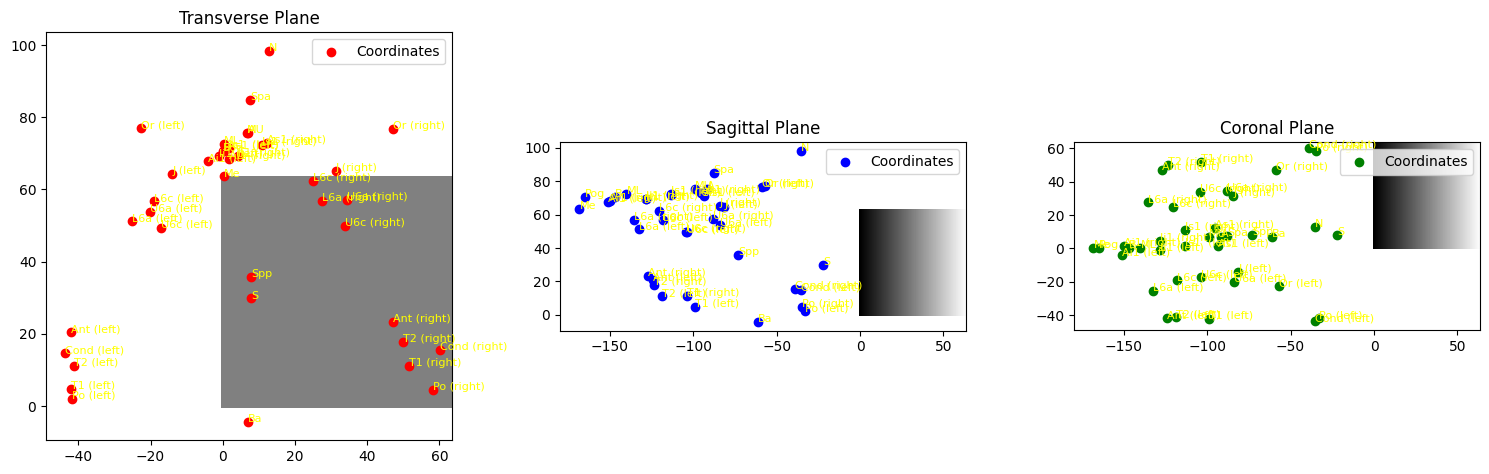

In [ ]:
import matplotlib.pyplot as plt

# Create a synthetic volume with a gradient effect
synthetic_volume = np.zeros(volume_shape, dtype=np.float32)

# Create a gradient effect in the synthetic volume
for z in range(64):
    synthetic_volume[:, :, z] = z / 64.0

# Function to plot original coordinates on the synthetic volume with gradient background
def plot_coordinates_on_slices(volume, coordinates, labels):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Transverse Plane
    axs[0].imshow(volume[:, :, volume.shape[2] // 2], cmap='gray', vmin=0, vmax=1, origin='lower')
    axs[0].scatter(coordinates[:, 0], coordinates[:, 1], color='red', label='Coordinates')

    # Add labels to the points
    for i, txt in enumerate(labels):
        axs[0].annotate(txt, (float(coordinates[i, 0]), float(coordinates[i, 1])), fontsize=8, color='yellow')

    axs[0].set_title('Transverse Plane')
    axs[0].legend()
    axs[0].axis('on')

    # Sagittal Plane
    axs[1].imshow(volume[:, volume.shape[1] // 2, :], cmap='gray', vmin=0, vmax=1, origin='lower')
    axs[1].scatter(coordinates[:, 2], coordinates[:, 1], color='blue', label='Coordinates')

    # Add labels to the points
    for i, txt in enumerate(labels):
        axs[1].annotate(txt, (float(coordinates[i, 2]), float(coordinates[i, 1])), fontsize=8, color='yellow')

    axs[1].set_title('Sagittal Plane')
    axs[1].legend()
    axs[1].axis('on')

    # Coronal Plane
    axs[2].imshow(volume[volume.shape[0] // 2, :, :], cmap='gray', vmin=0, vmax=1, origin='lower')
    axs[2].scatter(coordinates[:, 2], coordinates[:, 0], color='green', label='Coordinates')

    # Add labels to the points
    for i, txt in enumerate(labels):
        axs[2].annotate(txt, (float(coordinates[i, 2]), float(coordinates[i, 0])), fontsize=8, color='yellow')

    axs[2].set_title('Coronal Plane')
    axs[2].legend()
    axs[2].axis('on')

    plt.tight_layout()
    plt.show()

# Extract labels from synthetic_coordinates_df dataset
synthetic_labels = synthetic_coordinates_df['label'].values

# Plot the coordinates on the synthetic volume slices with gradient effect and yellow labels
plot_coordinates_on_slices(synthetic_volume, synthetic_coordinates[0], synthetic_labels)


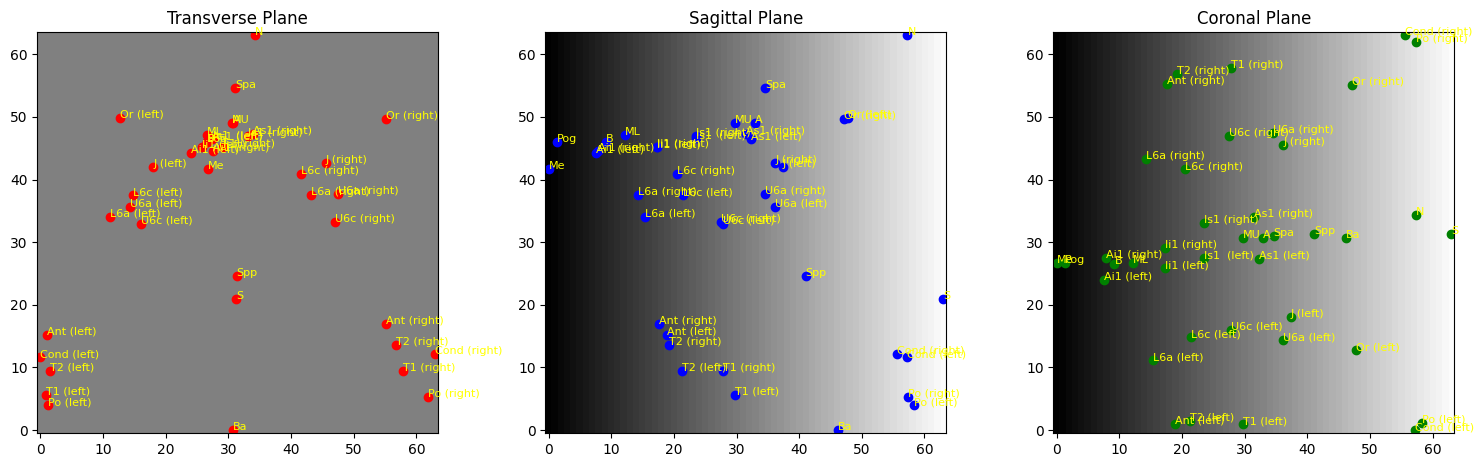

In [ ]:
# Normalizing the coordinates for the range [0, 63] to fit within the volume shape (64x64x64)
def normalize_coordinates(coordinates):
    # Normalize each coordinate (X, Y, Z) separately
    min_vals = np.min(coordinates, axis=0)
    max_vals = np.max(coordinates, axis=0)

    normalized_coordinates = (coordinates - min_vals) / (max_vals - min_vals) * 63
    return normalized_coordinates

# Function to plot normalized coordinates on the synthetic volume with yellow labels (landmarks)
def plot_normalized_coordinates_with_landmarks(volume, coordinates, labels):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Transverse Plane
    axs[0].imshow(volume[:, :, volume.shape[2] // 2], cmap='gray', vmin=0, vmax=1, origin='lower')
    axs[0].scatter(coordinates[:, 0], coordinates[:, 1], color='red')

    # Add yellow labels for the points (convert coordinates to float for annotation)
    for i, txt in enumerate(labels):
        axs[0].annotate(txt, (float(coordinates[i, 0]), float(coordinates[i, 1])), fontsize=8, color='yellow')

    axs[0].set_title('Transverse Plane')
    axs[0].axis('on')

    # Sagittal Plane
    axs[1].imshow(volume[:, volume.shape[1] // 2, :], cmap='gray', vmin=0, vmax=1, origin='lower')
    axs[1].scatter(coordinates[:, 2], coordinates[:, 1], color='blue')

    for i, txt in enumerate(labels):
        axs[1].annotate(txt, (float(coordinates[i, 2]), float(coordinates[i, 1])), fontsize=8, color='yellow')

    axs[1].set_title('Sagittal Plane')
    axs[1].axis('on')

    # Coronal Plane
    axs[2].imshow(volume[volume.shape[0] // 2, :, :], cmap='gray', vmin=0, vmax=1, origin='lower')
    axs[2].scatter(coordinates[:, 2], coordinates[:, 0], color='green')

    for i, txt in enumerate(labels):
        axs[2].annotate(txt, (float(coordinates[i, 2]), float(coordinates[i, 0])), fontsize=8, color='yellow')

    axs[2].set_title('Coronal Plane')
    axs[2].axis('on')

    plt.tight_layout()
    plt.show()

# Normalize the coordinates for plotting
normalized_coordinates = normalize_coordinates(synthetic_coordinates[0])

# Plot the normalized coordinates on the synthetic volume slices with yellow labels (landmarks)
plot_normalized_coordinates_with_landmarks(synthetic_volume, normalized_coordinates, synthetic_labels)


##**EXTENDING MODEL ARCHITECTURE TO 3D**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

# First 3D Convolutional layer (based on the paper's filter size and activation function)
model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(64, 64, 64, 1)))  # Input shape (volume size + channel)
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling with pool size (2, 2, 2)

# Second 3D Convolutional layer (based on the paper's architecture)
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third 3D Convolutional layer (inspired by the architecture in the paper)
model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fourth layer for deeper feature extraction
model.add(Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Global Average Pooling to reduce the dimensions before the fully connected layer
model.add(GlobalAveragePooling3D())

# Fully connected (Dense) layers
model.add(Dense(256, activation='relu'))  # Inspired by the paper's fully connected layers
model.add(Dropout(0.5))  # Dropout for regularization to avoid overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer for predicting 123 coordinates (41 landmarks * 3 coordinates)
model.add(Dense(123, activation='linear'))  # Linear activation for regression task (coordinates)

# Compile the model with Adam optimizer and Mean Squared Error (MSE) loss function
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mse'])

# Print model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 62, 62, 62, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 31, 31, 31, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 29, 29, 29, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 14, 14, 14, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 12, 12, 12, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 6, 6, 6, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 4, 4, 4, 256)        │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 2, 2, 2, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 123)                 │          15,867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,277,115 (4.87 MB)

 Trainable params: 1,277,115 (4.87 MB)

 Non-trainable params: 0 (0.00 B)



### **1. The 2D Architecture from the Paper**:
The original paper uses a **2D Convolutional Neural Network (CNN)** to predict the coordinates (X, Y) of cephalometric landmarks on 2D radiographs. Here's a breakdown of the 2D architecture:
- **2D Convolutional Layers**: Extract spatial features from 2D images using filters (kernels).
- **Max Pooling Layers**: Downsample the feature maps, reducing spatial dimensions and computational complexity.
- **Fully Connected Layers**: These layers are used to predict the final coordinates.
- **Output Layer**: In the original 2D setup, this output the (X, Y) coordinates for each landmark.

### **2. Extending the Architecture to 3D**:
The task involved extending this 2D architecture to handle **3D data** (i.e., volumetric medical images).

#### **Key Adjustments for 3D Data**:

1. **Input Data Shape**:
   - **2D CNN (in the paper)**: Takes 2D images (e.g., shape `(H, W, C)`, where H is height, W is width, and C is the number of channels).
   - **3D CNN (my extension)**: Takes **3D volumes** (e.g., shape `(D, H, W, C)`, where D is depth, H is height, W is width, and C is the number of channels). In my case, the volumes have the shape `(64, 64, 64, 1)` for each 3D image, which includes the depth (Z-axis).

2. **3D Convolutional Layers**:
   - In the original paper, 2D convolutional layers were used to extract features from the 2D input images.
   - I've replaced these with **3D convolutional layers** (`Conv3D`), which now extract spatial features across **three dimensions** (height, width, and depth) rather than two.
     - Example: I applied `Conv3D` with filters like 32, 64, 128, and 256 to extract deeper features across 3D space.

3. **Max Pooling for Dimensionality Reduction**:
   - In the 2D CNN, **2D MaxPooling** I used to reduce the height and width dimensions of the feature maps.
   - In the extension, I used **3D MaxPooling** (`MaxPooling3D`), which reduces the dimensions of the 3D feature maps (depth, height, width).
     - This helps in reducing the computational complexity while preserving essential features.

4. **Global Average Pooling**:
   - In both architectures, global pooling layers are used to reduce the number of parameters before passing the features to the fully connected layers.
   - I applied **Global Average Pooling** over 3D data (`GlobalAveragePooling3D`), reducing the entire 3D feature map to a single vector for each filter.

5. **Fully Connected Layers (Dense Layers)**:
   - Both the 2D and 3D architectures use **Dense layers** for making predictions.
   - In my 3D CNN, after the feature extraction layers, you added **fully connected (dense) layers** to predict the final coordinates (X, Y, Z) for the landmarks.
   - I also included **Dropout layers** for regularization to prevent overfitting.

6. **Output Layer**:
   - In the original 2D CNN, the output layer predicted **two coordinates (X, Y)**.
   - In my 3D CNN, the output layer predicts **three coordinates (X, Y, Z)** since we are working with 3D data.

#### **3. Overall Architecture Comparison**:
- **2D CNN (Paper)**:
  - Input: 2D images (H, W, C)
  - Convolutional layers: Extract 2D features
  - MaxPooling: Reduces 2D spatial dimensions
  - Output: Predicts (X, Y) coordinates for landmarks.
  
- **3D CNN (My Extension)**:
  - Input: 3D volumes (D, H, W, C)
  - Convolutional layers: Extract 3D features across three spatial dimensions
  - MaxPooling: Reduces 3D spatial dimensions
  - Global Average Pooling: Reduces feature maps before fully connected layers
  - Output: Predicts (X, Y, Z) coordinates for landmarks.

---




##**OPTIMIZATION/TRAINING**

In [ ]:
print(f"Shape of synthetic_volumes: {synthetic_volumes.shape}")
print(f"Shape of normalized_coordinates: {normalized_coordinates.shape}")


Shape of synthetic_volumes: (100, 64, 64, 64)
Shape of normalized_coordinates: (41, 3)


In [ ]:

# current set of coordinates for a single volume (41 landmarks, 3 coordinates)
# Shape: (41, 3)

# Replicate the coordinates for all 100 volumes
normalized_coordinates = np.tile(normalized_coordinates, (100, 1, 1))

# Check the shape
print(f"Shape of normalized_coordinates after replication: {normalized_coordinates.shape}")

Shape of normalized_coordinates after replication: (100, 41, 3)


In [ ]:
# Flatten the coordinates for each volume to a single vector of 123 values (41 landmarks * 3 coordinates)
y = normalized_coordinates.reshape((normalized_coordinates.shape[0], -1))  # Shape becomes (100, 123)

# Check the shape of the flattened coordinates
print(f"Shape of y (flattened coordinates): {y.shape}")  # Should be (100, 123)

Shape of y (flattened coordinates): (100, 123)


In [ ]:

from sklearn.model_selection import train_test_split

# Synthetic_volumes is an array of 100 3D volumes, each of shape (64, 64, 64)
# Normalized_coordinates is an array of size (100, 41, 3), where 41 is the number of landmarks and 3 is (X, Y, Z)

# Flatten the coordinates for each volume to a single vector of 123 values (41 landmarks * 3 coordinates)
y = normalized_coordinates.reshape((normalized_coordinates.shape[0], -1))  # Shape becomes (100, 123)

# Split the **volumes** and their corresponding full set of landmarks (labels)
X_train, X_test, y_train, y_test = train_test_split(synthetic_volumes, y, test_size=0.2, random_state=42)

# Reshape X_train and X_test to add a channel dimension for Conv3D
X_train = np.expand_dims(X_train, axis=-1)  # Shape: (80, 64, 64, 64, 1)
X_test = np.expand_dims(X_test, axis=-1)    # Shape: (20, 64, 64, 64, 1)

# Check the shapes of the data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (80, 64, 64, 64, 1), y_train shape: (80, 123)
X_test shape: (20, 64, 64, 64, 1), y_test shape: (20, 123)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Define callbacks for optimization and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='min', verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[reduce_lr, model_checkpoint, early_stopping],
    verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 618ms/step - loss: 1247.2344 - mse: 1247.2344 - val_loss: 1245.9706 - val_mse: 1245.9706 - learning_rate: 1.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 1245.4498 - mse: 1245.4498 - val_loss: 1242.8104 - val_mse: 1242.8104 - learning_rate: 1.0000e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 1241.1884 - mse: 1241.1884 - val_loss: 1235.8701 - val_mse: 1235.8701 - learning_rate: 1.0000e-04
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 1236.0284 - mse: 1236.0284 - val_loss: 1221.4207 - val_mse: 1221.4207 - learning_rate: 1.0000e-04
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 1216.4139 - mse: 1216.4139 - val_loss: 1193.3263 - val_mse: 1193.3263 - learning_rate: 1.0000e-04
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 1193.7649 - mse: 1193.7649 - val_loss: 1142.1812 - val_mse: 1142.1812 - learning_rate: 1.0000e-04
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss

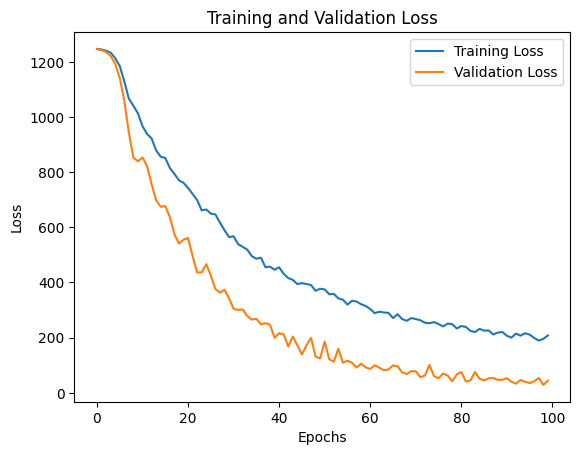

In [ ]:


# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



1. **Decreasing Loss**: Both the **training** and **validation loss** decrease consistently over the epochs, showing that the model is learning effectively from the data and improving its predictions.

2. **Stable Validation**: The **validation loss** remains lower than the training loss and stabilizes towards the end, indicating that the model is generalizing well without overfitting to the training data.

3. **Optimized Training**: The steady decline and convergence of both losses demonstrate that the optimization routine, including **early stopping** and **learning rate reduction**, successfully prevented overfitting and ensured efficient learning.


Here's a detailed explanation of how the **training** and **optimization** were done.

### **1. Preparing the Data for Training**:
#### **Synthetic Data Generation**:
- **Synthetic Volumes**: I created **100 synthetic 3D volumes**, each of shape `(64, 64, 64)`, representing simplified medical imaging data. These volumes serve as input data for the model. The shape `(64, 64, 64)` refers to the spatial dimensions of each synthetic volume, which is a smaller version of real-world volumetric data.
  
- **Landmark Coordinates**: I generated **41 landmarks** for each volume, where each landmark had three coordinates representing the **transversal, sagittal, and vertical** planes (X, Y, Z). This resulted in the shape `(100, 41, 3)`, where `100` is the number of volumes, `41` is the number of landmarks per volume, and `3` represents the coordinates for each landmark.

#### **Coordinate Normalization**:
- I normalized the coordinates using **min-max normalization** to ensure they fall within the range of the volume (64x64x64). This ensures that the coordinates correspond to valid locations within each volume.
  
#### **Flattening the Coordinates**:
- I flattened the coordinates from the shape `(100, 41, 3)` to `(100, 123)`:
  - Each volume had 41 landmarks, and each landmark had 3 coordinates (X, Y, Z). This means each volume has a total of **123 values** representing the landmarks' coordinates.
  
#### **Splitting the Data**:
-I split the dataset into **training** and **testing** sets using `train_test_split`. This ensures that 80% of the data is used for training, and 20% is reserved for testing.
  - `X_train`: The synthetic volumes for training, with a shape of `(80, 64, 64, 64, 1)` (80 training volumes, each with a single channel).
  - `y_train`: The corresponding landmark coordinates for each training volume, with a shape of `(80, 123)`.
  - `X_test`: The synthetic volumes for testing, with a shape of `(20, 64, 64, 64, 1)` (20 testing volumes).
  - `y_test`: The corresponding landmark coordinates for each testing volume, with a shape of `(20, 123)`.

---

### **2. The Training Process**:
The **3D CNN model** was trained using the prepared dataset. Here's how the process worked:

#### **Model Architecture**:
- The model architecture we used consists of **3D convolutional layers** (`Conv3D`) to extract spatial features from the 3D volumes. This mimics the approach in the paper but extends it to 3D data (i.e., extracting features across depth, height, and width).
- After several layers of feature extraction, we used **fully connected layers** to predict the **X, Y, Z** coordinates of the 41 landmarks.

#### **Loss Function and Metric**:
- **Loss Function**: I used **Mean Squared Error (MSE)** as the loss function. MSE is common in regression problems where we predict continuous values (in this case, the coordinates of the landmarks). The model tries to minimize the squared difference between the predicted coordinates and the actual coordinates.
  
- **Metric**: I also used MSE as the evaluation metric during training and testing, providing insight into how well the model is predicting the landmark coordinates.

---

### **3. Training Optimization**:
I included various **callbacks** during the training process to optimize the model's performance:

#### **Early Stopping**:
- **EarlyStopping** was used to prevent the model from overfitting. If the validation loss did not improve for 20 consecutive epochs, training was stopped, and the model weights were restored to the best-performing epoch.
  - This is especially useful because training a model for too many epochs can cause it to overfit to the training data, resulting in poor performance on the testing set.

#### **ReduceLROnPlateau**:
- This callback **reduces the learning rate** by a factor of 0.1 if the validation loss plateaus (i.e., it doesn't improve for 10 consecutive epochs). This allows the model to converge more effectively by taking smaller steps in the parameter space when it's nearing an optimal solution.

#### **ModelCheckpoint**:
- **ModelCheckpoint** saved the model that performed best on the validation set (based on validation loss).
---

### **4. Training Outcome**:
During the training process, the model goes through multiple epochs where:
- It tries to learn the relationship between the 3D volume (input) and the corresponding 123 values (landmark coordinates) for each volume (output).
- The **early stopping** and **learning rate reduction** help the model avoid overfitting and ensure better generalization to unseen test data.

---

